In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.calculate_index import format_df, calculate_index, weight_domains, print_index_summary, min_max_standardize
from scripts.utils.index_plot import index_plot, index_domain_plot

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data'
output_folder = 'aws_csvs'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data.


In [3]:
built_domain = pd.read_csv(r'aws_csvs/built_domain_index_calculation.csv')
governance_domain = pd.read_csv(r'aws_csvs/governance_domain_index_calculation.csv')
natural_domain = pd.read_csv(r'aws_csvs/natural_domain_index_calculation.csv')
society_domain = pd.read_csv(r'aws_csvs/society_economy_domain_index_calculation.csv')
climate_domain = pd.read_csv(r'aws_csvs/climate_domain_index_calculation.csv')

In [4]:
# Keep only the first two columns
built_domain_cleaned = built_domain.iloc[:, :2]
governance_domain_cleaned = governance_domain.iloc[:, :2]
natural_domain_cleaned = natural_domain.iloc[:, :2]
society_domain_cleaned = society_domain.iloc[:, :2]

# For climate domain, keep first seven columns
climate_domain_cleaned = climate_domain.iloc[:, :7]

Next, we'll read in the synthetic climate indicator data as well, so we can calculate the Index across California. 

In [5]:
merged_domains = pd.merge(governance_domain_cleaned, built_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, natural_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, society_domain_cleaned, on='GEOID', how='left')

In [6]:
# Ensure all values in GEOID are strings
merged_domains['GEOID'] = merged_domains['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
merged_domains['GEOID'] = merged_domains['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max() + 1)

# Rename the standardized columns for simplicity
merged_domains = merged_domains.rename(columns={
    'summed_indicators_governance_domain_min_max_standardized':'governance_domain_index',
    'summed_indicators_built_domain_min_max_standardized':'built_domain_index',
    'summed_indicators_natural_domain_min_max_standardized':'natural_systems_domain_index', 
    'summed_indicators_society_economy_domain_min_max_standardized':'society_economy_domain_index'     
})

# Display the dataframe
merged_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index
0,06001400100,0.657823,0.701072,0.706555,0.704602
1,06001400200,0.657823,0.754271,0.454009,0.695877
2,06001400300,0.657823,0.750204,0.854000,0.746512
3,06001400400,0.657823,0.758585,0.837761,0.770337
4,06001400500,0.657823,0.754902,0.829855,0.796901
...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060
9125,06115041001,0.638738,0.895790,0.749494,0.740463
9126,06115041002,0.638738,0.879166,0.652535,0.715148
9127,06115041101,0.638738,0.921867,0.571603,0.747091


In [7]:
all_domains = merged_domains.copy()
all_domains['built_median'] = merged_domains['built_domain_index'].median()
all_domains['natural_systems_median'] = merged_domains['natural_systems_domain_index'].median()
all_domains['society_economy_median'] = merged_domains['society_economy_domain_index'].median()

all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649
...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649


In [8]:
def calculate_adjusted_value(row, category):
    category_median_col = f'{category}_median'
    category_col = f'{category}_domain_index'
    adjusted_col = f'{category}_tract_adjusted'
    return (row[category_col] - row[category_median_col]) / row[category_median_col]

# Loop through each row and calculate the adjusted value for each category
for index, row in all_domains.iterrows():
    for category in ['natural_systems', 'society_economy', 'built']:
        adjusted_value = calculate_adjusted_value(row, category)
        adjusted_col = f'{category}_tract_adjusted'
        all_domains.at[index, adjusted_col] = adjusted_value

# Display the DataFrame
all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649,-0.010547,-0.084515,0.058352
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649,-0.364211,-0.095851,0.138661
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649,0.195933,-0.030062,0.132523
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649,0.173191,0.000895,0.145175
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649,0.162121,0.035409,0.139614
...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649,0.043171,-0.093015,0.270502
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649,0.049584,-0.037922,0.352302
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649,-0.086197,-0.070813,0.327205
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649,-0.199533,-0.029309,0.391667


Bring in Climate Data

In [9]:
climate_domain_cleaned

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized
0,6001400100,0.247113,0.035382,0.237421,0.001302,1.000000,0.046216
1,6001400200,0.225972,0.035382,0.213103,0.001047,0.866120,0.038191
2,6001400300,0.225258,0.037296,0.171471,0.001047,1.000000,0.042742
3,6001400400,0.216269,0.037296,0.171471,0.001047,0.996407,0.038857
4,6001400500,0.212934,0.037296,0.171471,0.001047,0.914342,0.042780
...,...,...,...,...,...,...,...
9124,6115040902,0.309647,0.000000,0.837804,0.019426,0.000000,0.074858
9125,6115041001,0.361374,0.000000,0.811620,0.017881,0.000000,0.145283
9126,6115041002,0.334189,0.000000,0.834996,0.021774,0.000000,0.100874
9127,6115041101,0.408105,0.000000,0.984481,0.059640,0.000000,0.136311


In [10]:
slr_mask_data = r'C:/Users/jesse/eagle/carb-climate-index-8/scripts/utils/slr_mask_layer.csv'
slr_mask = pd.read_csv(slr_mask_data)
slr_mask = slr_mask.drop(columns={'county', 'geometry', 'COUNTYFP'})

In [11]:
slr_mask

,GEOID,slr_impacted
0,6085504321,1
1,6085504410,1
2,6085507003,1
3,6085507004,1
4,6085502204,1
...,...,...
9124,6059001303,1
9125,6059001304,1
9126,6059001401,1
9127,6013367200,1


In [12]:
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].astype(str)
slr_mask['GEOID'] = slr_mask['GEOID'].astype(str)

processed_climate_df = pd.merge(climate_domain_cleaned, slr_mask, on='GEOID', how='left')
processed_climate_df

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized,slr_impacted
0,6001400100,0.247113,0.035382,0.237421,0.001302,1.000000,0.046216,1
1,6001400200,0.225972,0.035382,0.213103,0.001047,0.866120,0.038191,1
2,6001400300,0.225258,0.037296,0.171471,0.001047,1.000000,0.042742,1
3,6001400400,0.216269,0.037296,0.171471,0.001047,0.996407,0.038857,1
4,6001400500,0.212934,0.037296,0.171471,0.001047,0.914342,0.042780,1
...,...,...,...,...,...,...,...,...
9124,6115040902,0.309647,0.000000,0.837804,0.019426,0.000000,0.074858,0
9125,6115041001,0.361374,0.000000,0.811620,0.017881,0.000000,0.145283,0
9126,6115041002,0.334189,0.000000,0.834996,0.021774,0.000000,0.100874,0
9127,6115041101,0.408105,0.000000,0.984481,0.059640,0.000000,0.136311,0


In [13]:
processed_climate_df.loc[processed_climate_df['slr_impacted'] == 0, 'sea_level_rise_exposure_loss_product_min_max_standardized'] = np.nan

In [19]:
processed_climate_df

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized,slr_impacted
0,6001400100,0.247113,0.035382,0.237421,0.001302,1.000000,0.046216,1
1,6001400200,0.225972,0.035382,0.213103,0.001047,0.866120,0.038191,1
2,6001400300,0.225258,0.037296,0.171471,0.001047,1.000000,0.042742,1
3,6001400400,0.216269,0.037296,0.171471,0.001047,0.996407,0.038857,1
4,6001400500,0.212934,0.037296,0.171471,0.001047,0.914342,0.042780,1
...,...,...,...,...,...,...,...,...
9124,6115040902,0.309647,0.000000,0.837804,0.019426,NaN,0.074858,0
9125,6115041001,0.361374,0.000000,0.811620,0.017881,NaN,0.145283,0
9126,6115041002,0.334189,0.000000,0.834996,0.021774,NaN,0.100874,0
9127,6115041101,0.408105,0.000000,0.984481,0.059640,NaN,0.136311,0


In [21]:
# Ensure all values in GEOID are strings
processed_climate_df['GEOID'] = processed_climate_df['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
processed_climate_df['GEOID'] = processed_climate_df['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max())

processed_climate_df = processed_climate_df.drop(columns='slr_impacted')

# Display the dataframe
processed_climate_df

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized
0,06001400100,0.247113,0.035382,0.237421,0.001302,1.000000,0.046216
1,06001400200,0.225972,0.035382,0.213103,0.001047,0.866120,0.038191
2,06001400300,0.225258,0.037296,0.171471,0.001047,1.000000,0.042742
3,06001400400,0.216269,0.037296,0.171471,0.001047,0.996407,0.038857
4,06001400500,0.212934,0.037296,0.171471,0.001047,0.914342,0.042780
...,...,...,...,...,...,...,...
9124,06115040902,0.309647,0.000000,0.837804,0.019426,NaN,0.074858
9125,06115041001,0.361374,0.000000,0.811620,0.017881,NaN,0.145283
9126,06115041002,0.334189,0.000000,0.834996,0.021774,NaN,0.100874
9127,06115041101,0.408105,0.000000,0.984481,0.059640,NaN,0.136311


In [22]:
core_and_climate_domains = pd.merge(all_domains, processed_climate_df, on='GEOID', how='left')

In [23]:
core_and_climate_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649,-0.010547,-0.084515,0.058352,0.247113,0.035382,0.237421,0.001302,1.000000,0.046216
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649,-0.364211,-0.095851,0.138661,0.225972,0.035382,0.213103,0.001047,0.866120,0.038191
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649,0.195933,-0.030062,0.132523,0.225258,0.037296,0.171471,0.001047,1.000000,0.042742
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649,0.173191,0.000895,0.145175,0.216269,0.037296,0.171471,0.001047,0.996407,0.038857
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649,0.162121,0.035409,0.139614,0.212934,0.037296,0.171471,0.001047,0.914342,0.042780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649,0.043171,-0.093015,0.270502,0.309647,0.000000,0.837804,0.019426,NaN,0.074858
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649,0.049584,-0.037922,0.352302,0.361374,0.000000,0.811620,0.017881,NaN,0.145283
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649,-0.086197,-0.070813,0.327205,0.334189,0.000000,0.834996,0.021774,NaN,0.100874
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649,-0.199533,-0.029309,0.391667,0.408105,0.000000,0.984481,0.059640,NaN,0.136311


## Custom Weighting

In [24]:
# different weighting
df_fire = weight_domains(core_and_climate_domains, society=1.11, built=1.13, natural=1.28)
df_fire = calculate_index(df_fire, 'wildfire_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_fire = df_fire.rename(columns={'calcrai_score':'wildfire_scenario_calcrai_score'})

df_fire.to_csv('calcrai_index_wildfire_scenario.csv', index=False)
print_index_summary(df_fire, 'wildfire_scenario_calcrai_score')

Min score / less resilience:  -6.25995905907302
Max score / more resilience:  3166.909269901031
Mean score / average resilience:  133.98109373541882
Median score / median resilience:  24.213434974961668


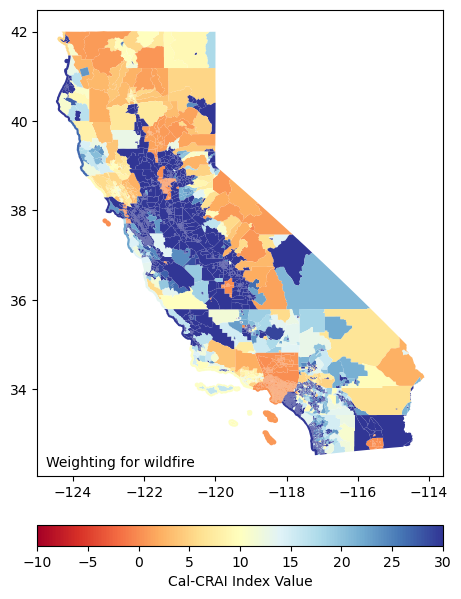

In [25]:
index_plot(df_fire, 'wildfire_scenario_calcrai_score', scenario='wildfire', vmin=-10, vmax=30)

In [26]:
df_heat = weight_domains(core_and_climate_domains, society=1.13, built=1.19, natural=1.26)
df_heat = calculate_index(df_heat, 'extreme_heat_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_heat = df_heat.rename(columns={'calcrai_score':'extreme_heat_scenario_calcrai_score'})

df_heat.to_csv('calcrai_index_heat_scenario.csv', index=False)
print_index_summary(df_heat, 'extreme_heat_scenario_calcrai_score')


Min score / less resilience:  -1.748598734072695
Max score / more resilience:  105.96241879676391
Mean score / average resilience:  4.113047576727365
Median score / median resilience:  2.5304503687079687


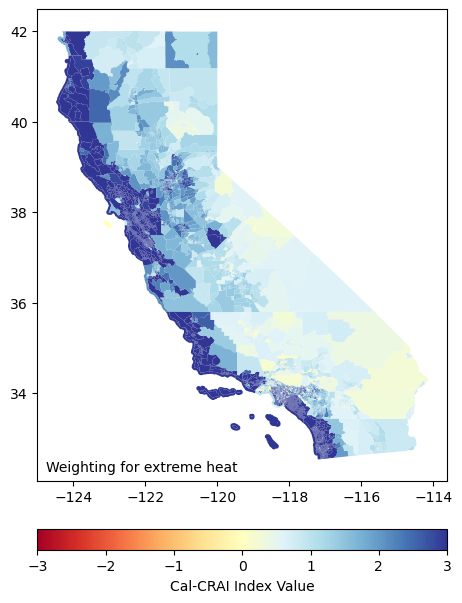

In [27]:
index_plot(df_heat, 'extreme_heat_scenario_calcrai_score', scenario='extreme heat')

In [28]:
df_inland_flooding = weight_domains(core_and_climate_domains, society=1.08, built=1.23, natural=1.41)
df_inland_flooding = calculate_index(df_inland_flooding, 'inland_flooding_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_inland_flooding = df_inland_flooding.rename(columns={'calcrai_score':'inland_flooding_scenario_calcrai_score'})

df_inland_flooding.to_csv('calcrai_index_inland_flooding_scenario.csv', index=False)
print_index_summary(df_inland_flooding, 'inland_flooding_scenario_calcrai_score')

Min score / less resilience:  -1.9237207011881954
Max score / more resilience:  328322.2413275348
Mean score / average resilience:  823.3111235339957
Median score / median resilience:  1.642041714465496


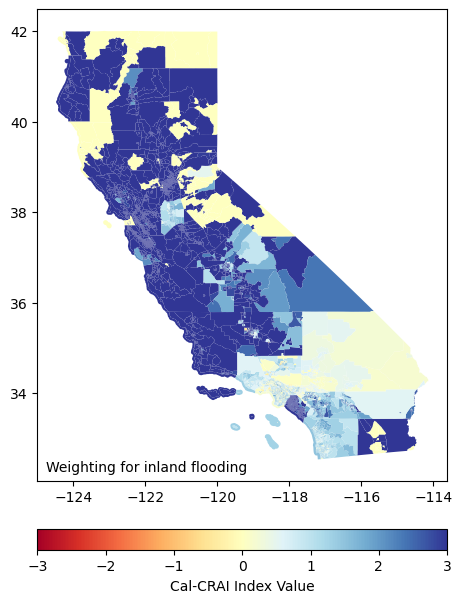

In [29]:
index_plot(df_inland_flooding, 'inland_flooding_scenario_calcrai_score', scenario='inland flooding')

In [30]:
df_sea_level_rise = weight_domains(core_and_climate_domains, society=1.1, built=1.25, natural=1.18)
df_sea_level_rise = calculate_index(df_sea_level_rise, 'sea_level_rise_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_sea_level_rise = df_sea_level_rise.rename(columns={'calcrai_score':'sea_level_rise_scenario_calcrai_score'})

df_sea_level_rise.to_csv('calcrai_index_inland_sea_level_rise_scenario.csv', index=False)
print_index_summary(df_sea_level_rise, 'sea_level_rise_scenario_calcrai_score')


Min score / less resilience:  -0.9911430798164045
Max score / more resilience:  602.3064816810661
Mean score / average resilience:  1.3567982763578121
Median score / median resilience:  0.8435182293195352


In [32]:
df_sea_level_rise

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized,calcrai_weighted,sea_level_rise_scenario_calcrai_score
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649,-0.010547,-0.084515,0.058352,0.247113,0.035382,0.237421,0.001302,1.000000,0.046216,0.636462,0.636462
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649,-0.364211,-0.095851,0.138661,0.225972,0.035382,0.213103,0.001047,0.866120,0.038191,0.419771,0.484657
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649,0.195933,-0.030062,0.132523,0.225258,0.037296,0.171471,0.001047,1.000000,0.042742,0.897130,0.897130
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649,0.173191,0.000895,0.145175,0.216269,0.037296,0.171471,0.001047,0.996407,0.038857,0.912281,0.915570
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649,0.162121,0.035409,0.139614,0.212934,0.037296,0.171471,0.001047,0.914342,0.042780,0.924090,1.010661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649,0.043171,-0.093015,0.270502,0.309647,0.000000,0.837804,0.019426,NaN,0.074858,0.821897,NaN
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649,0.049584,-0.037922,0.352302,0.361374,0.000000,0.811620,0.017881,NaN,0.145283,0.930751,NaN
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649,-0.086197,-0.070813,0.327205,0.334189,0.000000,0.834996,0.021774,NaN,0.100874,0.785264,NaN
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649,-0.199533,-0.029309,0.391667,0.408105,0.000000,0.984481,0.059640,NaN,0.136311,0.780470,NaN


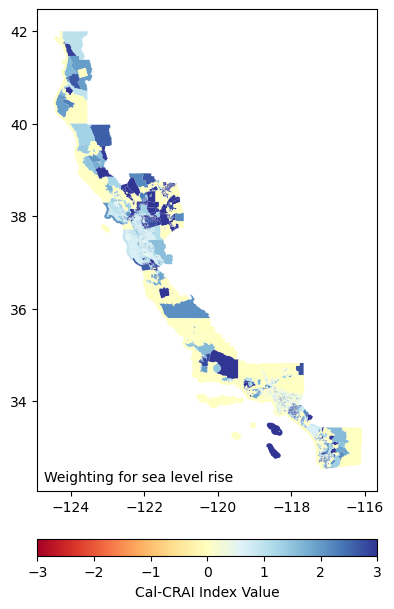

In [31]:
index_plot(df_sea_level_rise, 'sea_level_rise_scenario_calcrai_score', scenario='sea level rise')

In [33]:
df_drought = weight_domains(core_and_climate_domains, society=1.15, built=1.05, natural=1.42)
df_drought = calculate_index(df_drought, 'drought_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_drought = df_drought.rename(columns={'calcrai_score':'drought_scenario_calcrai_score'})

df_drought.to_csv('calcrai_index_drought_scenario.csv', index=False)
print_index_summary(df_drought, 'drought_scenario_calcrai_score')

Min score / less resilience:  -1.8488497318901955
Max score / more resilience:  121.80184577584397
Mean score / average resilience:  4.994781122651335
Median score / median resilience:  0.9524307446579952


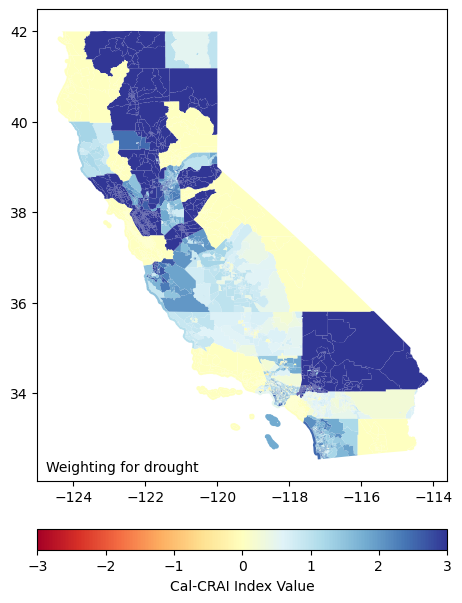

In [34]:
index_plot(df_drought, 'drought_scenario_calcrai_score', scenario='drought')

In [35]:
# List of dataframes to merge
dfs = [df_drought, df_fire, df_heat, df_sea_level_rise, df_inland_flooding]

# Keep only 'geoid' and columns ending with '_calcrai_score' in each dataframe
dfs = [df[['GEOID'] + [col for col in df.columns if col.endswith('_calcrai_score')]] for df in dfs]

# Merge all dataframes on 'geoid' using an outer join
from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, on='GEOID', how='outer'), dfs)

# View the resulting merged dataframe
merged_df

,GEOID,drought_scenario_calcrai_score,wildfire_scenario_calcrai_score,extreme_heat_scenario_calcrai_score,sea_level_rise_scenario_calcrai_score,inland_flooding_scenario_calcrai_score
0,06001400100,17.645637,484.355984,2.661664,0.636462,13.744315
1,06001400200,9.634091,366.855461,1.845303,0.484657,9.533857
2,06001400300,24.389858,858.678263,5.258128,0.897130,21.651242
3,06001400400,24.682492,870.956269,5.340157,0.915570,24.102971
4,06001400500,25.002315,882.171706,5.410880,1.010661,22.120348
...,...,...,...,...,...,...
9124,06115040902,0.000000,41.352753,0.969146,NaN,11.033811
9125,06115041001,0.000000,50.706730,1.132372,NaN,6.428958
9126,06115041002,0.000000,34.638709,0.918523,NaN,7.626617
9127,06115041101,0.000000,12.366236,0.766600,NaN,5.476652


In [36]:
# Binning into quartiles
binned_df = merged_df.copy()

# Define the columns to bin
columns_to_bin = [
    'drought_scenario_calcrai_score',
    'wildfire_scenario_calcrai_score',
    'extreme_heat_scenario_calcrai_score',
    'sea_level_rise_scenario_calcrai_score',
    'inland_flooding_scenario_calcrai_score',
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_df[column], 
        q=5, 
        labels=False, 
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_df = binned_df.drop(columns=columns_to_bin)
binned_df

Bin edges for drought_scenario_calcrai_score: [ -1.84884973   0.           0.56870337   1.6197807    2.52390396
 121.80184578]
Bin edges for wildfire_scenario_calcrai_score: [-6.25995906e+00  2.75123194e-01  9.48781509e+00  4.49970713e+01
  1.40456485e+02  3.16690927e+03]
Bin edges for extreme_heat_scenario_calcrai_score: [ -1.74859873   1.05393226   2.0048196    3.42104862   6.10077436
 105.9624188 ]
Bin edges for sea_level_rise_scenario_calcrai_score: [-9.91143080e-01  0.00000000e+00  4.94204302e-01  1.08142549e+00
  2.14877432e+00  6.02306482e+02]
Bin edges for inland_flooding_scenario_calcrai_score: [-1.92372070e+00  4.12627287e-01  1.25861303e+00  3.32968115e+00
  1.24010893e+01  3.28322241e+05]


,GEOID,drought_scenario_calcrai_score_quartile,wildfire_scenario_calcrai_score_quartile,extreme_heat_scenario_calcrai_score_quartile,sea_level_rise_scenario_calcrai_score_quartile,inland_flooding_scenario_calcrai_score_quartile
0,06001400100,4,4,2,2.0,4
1,06001400200,4,4,1,1.0,3
2,06001400300,4,4,3,2.0,4
3,06001400400,4,4,3,2.0,4
4,06001400500,4,4,3,2.0,4
...,...,...,...,...,...,...
9124,06115040902,0,2,0,NaN,3
9125,06115041001,0,3,1,NaN,3
9126,06115041002,0,2,0,NaN,3
9127,06115041101,0,2,0,NaN,3


In [37]:
binned_df.to_csv('binned_weighted_data.csv', index=False)

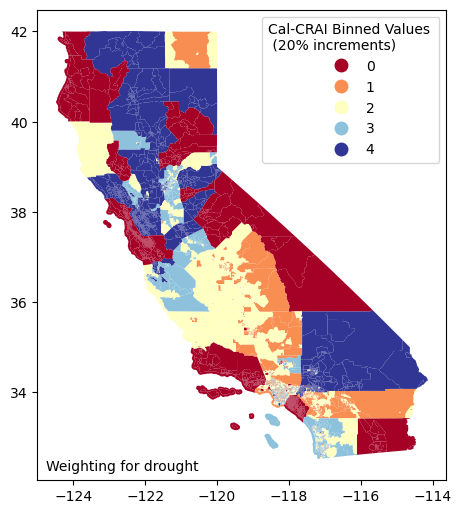

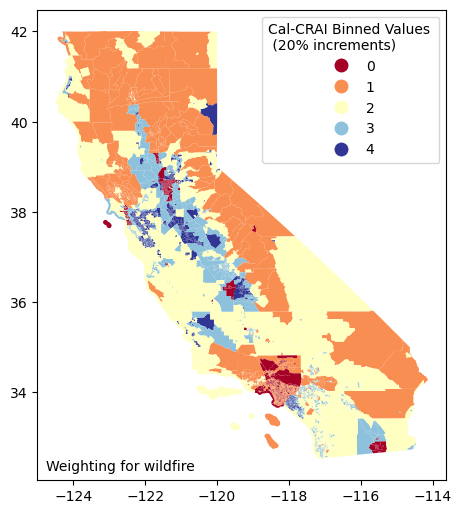

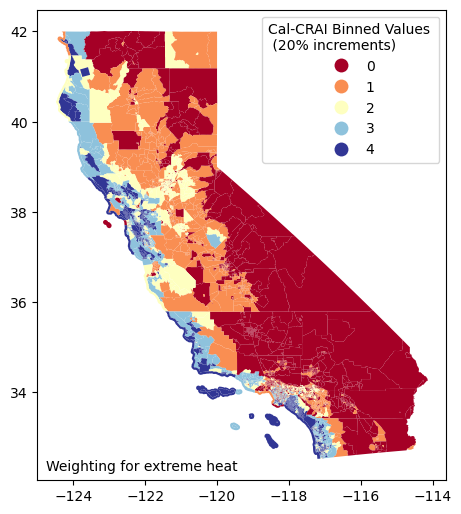

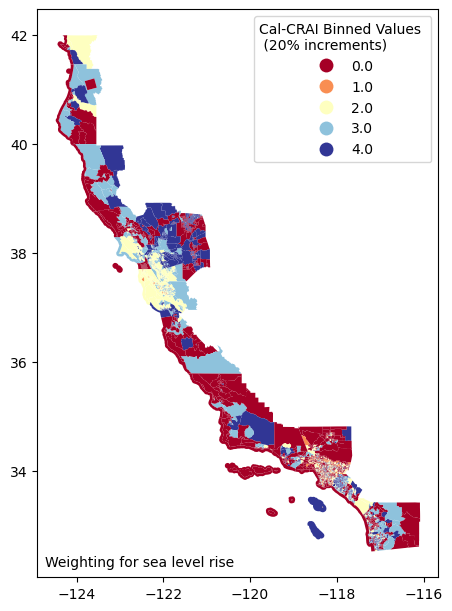

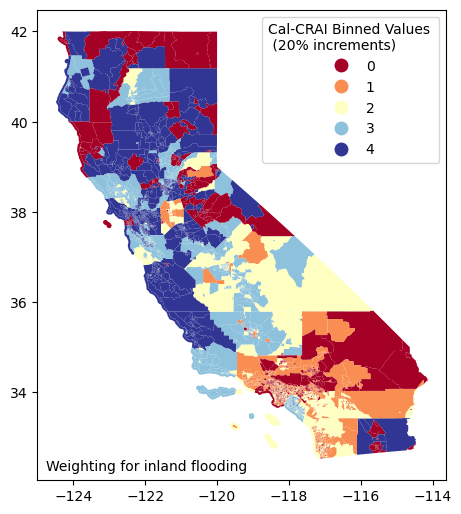

In [38]:
# List of binned columns
binned_columns = [
    'drought_scenario_calcrai_score_quartile',
    'wildfire_scenario_calcrai_score_quartile',
    'extreme_heat_scenario_calcrai_score_quartile',
    'sea_level_rise_scenario_calcrai_score_quartile',
    'inland_flooding_scenario_calcrai_score_quartile',
]

# Loop through each binned column and plot
for column in binned_columns:
    scenario_name = column.split('_scenario')[0]  # Get everything before '_scenario'
    scenario_name = scenario_name.replace('_', ' ')

    index_plot(binned_df, column, save=True, save_name=f'binned {scenario_name}', scenario=scenario_name, vmin=0, vmax=5, plot_type='discrete')

In [ ]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files = ['calcrai_wildfire_scenario_index.csv',
        'calcrai_heat_scenario_index.csv',
        'calcrai_inland_flooding_scenario_index.csv',
        'calcrai_index_inland_sea_level_rise_scenario.csv',
        'calcrai_index_drought_scenario.csv']

for file in files:
    upload_csv_aws([file], bucket_name, directory)